In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
from sklearn.model_selection import KFold
from scipy import interpolate
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm
from PIL import Image

In [ ]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

DIM = (224, 224)
EMBEDDING_SIZE = 128
model_path = './runs/224x224_ResNet18_AMSoftmax_20250409-172656/224x224_ResNet18_AMSoftmax_validation_20250409-172656.pt'


In [16]:
def calculate_roc(thresholds, embeddings1, embeddings2, actual_issame, nrof_folds=10):
    assert(embeddings1.shape[0] == embeddings2.shape[0])
    assert(embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)
    
    tprs = np.zeros((nrof_folds,nrof_thresholds))
    fprs = np.zeros((nrof_folds,nrof_thresholds))
    accuracy = np.zeros((nrof_folds))
    
    diff = np.subtract(embeddings1, embeddings2)
    dist = np.sum(np.square(diff),1)
    #dist = (embeddings1 * embeddings2).sum(axis=1)/2.
    indices = np.arange(nrof_pairs)
   
    best_thres = []

    for fold_idx, (train_set, test_set) in tqdm(enumerate(k_fold.split(indices)), total=nrof_folds, desc='calculate_roc'):
        
        # Find the best threshold for the fold
        acc_train = np.zeros((nrof_thresholds))
        for threshold_idx, threshold in tqdm(enumerate(thresholds), total=nrof_thresholds):
            _, _, acc_train[threshold_idx] = calculate_accuracy(threshold, dist[train_set], actual_issame[train_set])
        best_threshold_index = np.argmax(acc_train)
        for threshold_idx, threshold in enumerate(thresholds):
            tprs[fold_idx,threshold_idx], fprs[fold_idx,threshold_idx], _ = calculate_accuracy(threshold, dist[test_set], actual_issame[test_set])
        _, _, accuracy[fold_idx] = calculate_accuracy(thresholds[best_threshold_index], dist[test_set], actual_issame[test_set])

        tpr = np.mean(tprs,0)
        fpr = np.mean(fprs,0)
    return tpr, fpr, accuracy

def calculate_accuracy(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))
  
    tpr = 0 if (tp+fn==0) else float(tp) / float(tp+fn)
    fpr = 0 if (fp+tn==0) else float(fp) / float(fp+tn)
    acc = float(tp+tn)/dist.size
    return tpr, fpr, acc

def calculate_val_far(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    true_accept = np.sum(np.logical_and(predict_issame, actual_issame))
    false_accept = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    n_same = np.sum(actual_issame)
    n_diff = np.sum(np.logical_not(actual_issame))
    if n_same == 0:
        val = 0
    else:
        val = float(true_accept) / float(n_same)
    if n_diff == 0:
        far = 0
    else:
        far = float(false_accept) / float(n_diff)
    return val, far

  
def calculate_val(thresholds, embeddings1, embeddings2, actual_issame, far_target, nrof_folds=10):
    assert (embeddings1.shape[0] == embeddings2.shape[0])
    assert (embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)

    val = np.zeros(nrof_folds)
    far = np.zeros(nrof_folds)

    diff = np.subtract(embeddings1, embeddings2)
    dist = np.sum(np.square(diff), 1)
    indices = np.arange(nrof_pairs)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        # Find the threshold that gives FAR = far_target
        far_train = np.zeros(nrof_thresholds)
        for threshold_idx, threshold in enumerate(thresholds):
            _, far_train[threshold_idx] = calculate_val_far(threshold, dist[train_set], actual_issame[train_set])

        # Remove duplicate values from far_train before interpolation
        unique_far_train, unique_indices = np.unique(far_train, return_index=True)

        if len(unique_far_train) > 1 and np.max(far_train) >= far_target:  # Ensure we have at least two unique values to interpolate
            # Sort the unique values by their original indices to maintain the relationship with thresholds
            sorted_indices = np.argsort(unique_indices)
            unique_far_train = unique_far_train[sorted_indices]
            thresholds_for_interpolation = thresholds[unique_indices[sorted_indices]]  # Corresponding thresholds

            f = interpolate.interp1d(unique_far_train, thresholds_for_interpolation, kind='slinear',
                                         fill_value="extrapolate")  # Add fill_value
            threshold = f(far_target)
        else:
            threshold = 0.0

        val[fold_idx], far[fold_idx] = calculate_val_far(threshold, dist[test_set], actual_issame[test_set])

    val_mean = np.mean(val)
    far_mean = np.mean(far)
    val_std = np.std(val)
    return val_mean, val_std, far_mean

In [17]:
def evaluate(embeddings, actual_issame, nrof_folds=10):
    # Calculate evaluation metrics
    thresholds = np.arange(0, 4, 0.01)
    embeddings1 = embeddings[0::2]
    embeddings2 = embeddings[1::2]
    tpr, fpr, accuracy = calculate_roc(thresholds, embeddings1, embeddings2,
        np.asarray(actual_issame), nrof_folds=nrof_folds)
    thresholds = np.arange(0, 4, 0.001)
    val, val_std, far = calculate_val(thresholds, embeddings1, embeddings2,
        np.asarray(actual_issame), 1e-3, nrof_folds=nrof_folds)
    return tpr, fpr, accuracy, val, val_std, far

def get_paths(lfw_dir, pairs, file_ext):
    nrof_skipped_pairs = 0
    path_list = []
    issame_list = []
    for pair in pairs:

        if len(pair) == 3:
            path0 = os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[1])+'.'+file_ext)
            path1 = os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[2])+'.'+file_ext)
            issame = True
        elif len(pair) == 4:
            path0 = os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[1])+'.'+file_ext)
            path1 = os.path.join(lfw_dir, pair[2], pair[2] + '_' + '%04d' % int(pair[3])+'.'+file_ext)
            issame = False
        if os.path.exists(path0) and os.path.exists(path1):    # Only add the pair if both paths exist
            path_list += (path0,path1)
            issame_list.append(issame)
        else:
            print(path0,path1)
            nrof_skipped_pairs += 1
    if nrof_skipped_pairs>0:
        print('Skipped %d image pairs' % nrof_skipped_pairs)
    else:
        print('No skipped pairs')
    return path_list, issame_list

def read_pairs(pairs_filename):
    pairs = []
    with open(pairs_filename, 'r') as f:
        for line in f.readlines()[1:]:
            pair = line.strip().split()
            pairs.append(pair)
    return np.array(pairs, dtype=object)

In [18]:
def parse_fglfw_pairs(file_path, dataset_path):
    with open(file_path, "r", encoding="utf-8") as f:
        lines = [line.strip() for line in f.readlines()]

    sets = []
    idx = 0
    # Each set has 600 lines for matched (300 pairs) and 600 lines for mismatched (300 pairs)
    for _ in range(10):
        matched = []
        mismatched = []
        # Read 300 matched pairs (2 lines each)
        for i in range(300):
            # add dataset path to image paths
            matched.append((os.path.join(dataset_path, lines[idx + 2*i]), os.path.join(dataset_path, lines[idx + 2*i + 1])))
        idx += 600
        # Read 300 mismatched pairs (2 lines each)
        for i in range(300):
            # add dataset path to image paths
            mismatched.append((os.path.join(dataset_path, lines[idx + 2*i]), os.path.join(dataset_path, lines[idx + 2*i + 1])))
        idx += 600
        sets.append({"matched": matched, "mismatched": mismatched})

    return sets

In [19]:
def get_paths_FGLFW(lfw_dir, pairsFG, file_ext):
    nrof_skipped_pairs = 0
    path_list = []
    issame_list = []
    for pair_long in pairsFG:
        for pairs in pair_long['matched']:
            path0 = pairs[0]
            path1 = pairs[1]
            issame = True
            if os.path.exists(path0) and os.path.exists(path1):    # Only add the pair if both paths exist
                path_list += (path0,path1)
                issame_list.append(issame)
            else:
                print(path0,path1)
                nrof_skipped_pairs += 1
        for pairs in pair_long['mismatched']:
            path0 = pairs[0]
            path1 = pairs[1]
            issame = False
            if os.path.exists(path0) and os.path.exists(path1):    # Only add the pair if both paths exist
                path_list += (path0,path1)
                issame_list.append(issame)
            else:
                print(path0,path1)
                nrof_skipped_pairs += 1
    if nrof_skipped_pairs>0:
        print('Skipped %d image pairs' % nrof_skipped_pairs)
    else:
        print('No skipped pairs')
    return path_list, issame_list

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # self.relu = nn.PReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=10572, dropout=0.4):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(dropout)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        self.dropout(out)
        out = self.fc(out)
        out = F.normalize(out, p=2, dim=-1)
        return out

In [21]:
def load_model(model, path, device):
    state_dict = torch.load(path, map_location=device)
    # Create new OrderedDict without 'module.' prefix
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if k.startswith('module.'):
            name = k[7:] # remove 'module.' prefix
        else:
            name = k
        new_state_dict[name] = v
    
    # Load the weights
    model.load_state_dict(new_state_dict)
    # Set to evaluation mode
    model.eval()
    print(f"Model loaded from {path}")
    return model

In [ ]:
class Config:
    def __init__(self):
        self.lfw_dir = './lfw_cropped'
        self.file_ext = 'jpg'
        self.lfw_pairs = './fiftyone/lfw/lfw_funneled/pairs.txt'
        self.FGlfw_pairs = './fiftyone/lfw/lfw_funneled/pair_FGLFW.txt'

args = Config()

In [ ]:
embedding_model = ResNet18(EMBEDDING_SIZE)
embedding_model = load_model(embedding_model, model_path, device)

Model loaded from ./runs/224x224_ResNet18_AMSoftmax_20250409-172656/224x224_ResNet18_AMSoftmax_validation_20250409-172656.pt


In [ ]:
pairs = read_pairs(args.lfw_pairs)
path_list, issame_list = get_paths(args.lfw_dir, pairs, args.file_ext)

embedding_model.to(device)

# Define the transformations
class CustomNormalize:
    def __call__(self, img):
        # Convert PIL image to tensor
        img = transforms.ToTensor()(img)
        # Subtract 128 and divide by 128
        img = (img * 255.0 - 127.5) / 128.0
        return img

transform = transforms.Compose([
    transforms.Resize(DIM,interpolation=transforms.InterpolationMode.LANCZOS),  # Resize the image to the desired dimensions
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    # transforms.RandomRotation(30),  # Randomly rotate the image by up to 10 degrees
    # transforms.RandomVerticalFlip(),  # Randomly flip the image vertically
    # transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Randomly change brightness, contrast, saturation, and hue
    CustomNormalize()
])

# Function to load and preprocess images
def load_and_preprocess_image(path):
    try:
        img = Image.open(path)
        img = transform(img)
        return img
    except Exception as e:
        print(f"Error loading image {path}: {e}")
        return None

# Generate embeddings for all images
embeddings = []
labels = []
for path in tqdm(path_list, desc="Generating embeddings"):
    img = load_and_preprocess_image(path)
    if img is not None:
        img = img.unsqueeze(0).to(device)  # Add batch dimension and move to device
        with torch.no_grad():
            embedding = embedding_model(img)
        embeddings.append(embedding.cpu().numpy())
        
# Convert to numpy array and reshape
print(embeddings[0].shape)
embeddings = np.concatenate(embeddings, axis=0)
embeddings = np.reshape(embeddings, (len(path_list), -1))

# Evaluate the embeddings
tpr, fpr, accuracy, val, val_std, far = evaluate(embeddings, issame_list, nrof_folds=10)


print('Accuracy: %1.3f+-%1.3f' % (np.mean(accuracy), np.std(accuracy)))
print('Validation rate: %2.5f+-%2.5f @ FAR=%2.5f' % (val, val_std, far))

No skipped pairs


Generating embeddings: 100%|██████████| 12000/12000 [00:36<00:00, 328.03it/s]


(1, 128)


calculate_roc: 100%|██████████| 10/10 [00:00<00:00, 51.34it/s]


Accuracy: 0.964+-0.008
Validation rate: 0.87533+-0.01899 @ FAR=0.00100


In [25]:
FGpairs = parse_fglfw_pairs(args.FGlfw_pairs, args.lfw_dir)
FGpath_list, FGissame_list = get_paths_FGLFW(args.lfw_dir, FGpairs, args.file_ext)

print("Fine Grained LFW pairs: ", len(FGpath_list))
print("Fine Grained LFW issame list: ", len(FGissame_list))
print("Fine Grained LFW pairs: ", sum(FGissame_list))

FGembeddings = []
FGlabels = []
for path in tqdm(FGpath_list, desc="Generating embeddings"):
    img = load_and_preprocess_image(path)
    if img is not None:
        img = img.unsqueeze(0).to(device)  # Add batch dimension and move to device
        with torch.no_grad():
            embedding = embedding_model(img)
        FGembeddings.append(embedding.cpu().numpy())
        
# Convert to numpy array and reshape
print(FGembeddings[0].shape)
FGembeddings = np.concatenate(FGembeddings, axis=0)
FGembeddings = np.reshape(FGembeddings, (len(FGpath_list), -1))

# Evaluate the embeddings
FGtpr, FGfpr, FGaccuracy, FGval, FGval_std, FGfar = evaluate(FGembeddings, FGissame_list, nrof_folds=10)

print('Fine Grained Accuracy: %1.3f+-%1.3f' % (np.mean(FGaccuracy), np.std(FGaccuracy)))
print('Fine Grained Validation rate: %2.5f+-%2.5f @ FAR=%2.5f' % (FGval, FGval_std, FGfar))

No skipped pairs
Fine Grained LFW pairs:  12000
Fine Grained LFW issame list:  6000
Fine Grained LFW pairs:  3000


Generating embeddings: 100%|██████████| 12000/12000 [00:36<00:00, 330.65it/s]


(1, 128)


calculate_roc: 100%|██████████| 10/10 [00:00<00:00, 51.34it/s]


Fine Grained Accuracy: 0.919+-0.012
Fine Grained Validation rate: 0.51333+-0.02910 @ FAR=0.00100


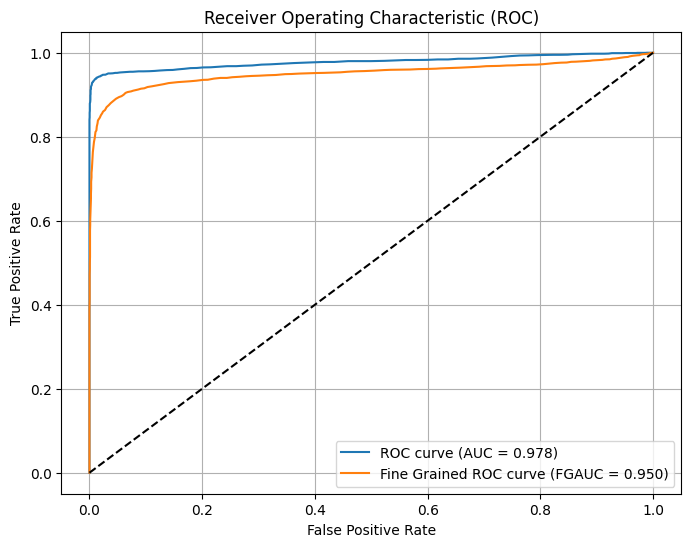

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
# --- Plotting Code ---
auc = roc_auc_score(issame_list, -np.sum(np.square(embeddings[0::2]-embeddings[1::2]), axis=1))  # Calculate AUC
FGauc = roc_auc_score(FGissame_list, -np.sum(np.square(FGembeddings[0::2]-FGembeddings[1::2]), axis=1))  # Calculate AUC

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')  # Add AUC to the legend
plt.plot(FGfpr, FGtpr, label=f'Fine Grained ROC curve (FGAUC = {FGauc:.3f})')  # Add AUC to the legend
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
# plt.savefig('roc_curve2.pdf', format='pdf', bbox_inches='tight')
# plt.savefig('roc_curve2.eps', format='eps', bbox_inches='tight')
plt.show()